In [7]:
#1.Transportation problems
import numpy as np


'''
Function to find the northwest corner

input: temp_source temp_dest arrays

returns: row and column value of NW corner
'''
def find_north_west_corner(temp_source,temp_dest):
    for i,s in enumerate(temp_source):
        if ( s != 0 ):
            for j,d in enumerate(temp_dest):
                if ( d != 0 ):
                    return (i,j)

    return False

'''
Function to apply northwest corner method

returns: Matrix of the costs for each cell
'''

def north_west_corner(sources,dest,costs):
    # temp_sources and dests are used to dectement costs
    temp_source = sources.copy()
    temp_dest = dest.copy()
    n_source,n_dests = costs.shape
    # To store assigned costs
    assigned = np.zeros(costs.shape)

    while find_north_west_corner(temp_source,temp_dest):
        x,y = find_north_west_corner(temp_source,temp_dest)
        min_cost = min(temp_source[x],temp_dest[y])
        temp_source[x] -= min_cost
        temp_dest[y] -= min_cost
        assigned[x][y] = min_cost
    return assigned

'''
Function to find cost given the assignments
'''
def get_cost(cost,assigned):
    total_cost = 0
    for c_r,a_r in zip(cost,assigned):
        for c,a in zip(c_r,a_r):
            total_cost+=c*a
    return total_cost



'''
Function to find the u and v values

input: sources,dest,costs,assigned
output: u,v values

This function is used to find the u and v values to find the penalty

'''
def find_uv_values(sources,dest,costs,assigned):
    # Finding u,v values to find the penalty
    U = [None for i in range(len(sources))]
    V = [None for i in range(len(dest))]
    U[0] = 0
    # Variable to check if the V and V columns are filled
    filled = False
    while not filled:
        # Iterating through columns to find Vi's
        for i,row in enumerate(assigned):
            for j,row_el in enumerate(row):
                # Only enter if U_i is assigned
                    if U[i] != None:
                    # If an assigned row
                        if row_el > 0 :
                            # If V is not filled
                            if V[j] == None:
                                # Assign new value for V_i
                                V[j] = costs[i][j] - U[i]
        # Iterating the rows to find U_i's
        assigned_T = np.transpose(np.array(assigned))
        for i,col in enumerate(assigned_T):
            for j,col_el in enumerate(col):
                # Only enter if V_i is assigned
                    if V[i] != None:
                    # If an assigned row
                        if col_el > 0 :
                            # If V is not filled
                            if U[j] == None:
                                # Assign new value for V_i
                                U[j] = costs[i][j] - V[i]

        # Checking if u and v are filled
        filled_u = True
        filled_v = True
        for u in U:
            if u == None:
                filled_u == False
        for v in V:
            if v == None:
                filled_v = False
        if filled_u and filled_v:
            filled = True
        else:
            filled = False
    return U,V

'''
Function to find the penalty values
P = u_i + v_j - c_ij

input: U,V,costs
output: penalty value matrix
'''
def get_penalties(U,V,cost,assigned):
    penalty = np.zeros(cost.shape)
    for i,u in enumerate(U):
        for j,v in enumerate(V):
            if assigned[i][j] == 0:
                penalty[i][j] = u+v-cost[i][j]
    return penalty

'''
Function to check if the given penalty matrix is optimal

input: penalty matrix
output: True if optimal else False
'''
def check_optimality(penalty):
    for row in penalty:
        for el in row:
            if el > 0:
                return False
    return True

'''
Finding the entering variable which has the maximum penalty
input: penalty matrix
'''
def get_entering_variable_position(penalty):
    penalty_copy = np.array(penalty)
    penalty_copy = penalty_copy.flatten()
    penalty_copy = np.sort(penalty_copy)
    position = np.where(penalty == penalty_copy[-1])
    return int(position[0]),int(position[1])

def get_next_cells(matrix, position):
    x,y = position
    next_cells = [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]
    next_cells = [
                    cell for cell in next_cells if
                    cell[0] >= 0
                    and cell[1] >= 0
                    and cell[0] < matrix.shape[0]
                    and cell[1] < matrix.shape[1]
                    and matrix[cell[0], cell[1]] != 0
                ]
    return next_cells


'''
Function to find the closed loop to be pivoted

input: cost,assigned,entering_variable

'''

def find_closed_loop(assigned, start, visited, path, check = 0):
    i, j = start
    visited[i, j] = 1

    next_cells = get_next_cells(assigned, start)
    for cell in next_cells:
        if visited[cell[0], cell[1]] == 0:
            if cell in path:
                return path
            else:
                visited[cell[0], cell[1]] = 1
                result = find_closed_loop(assigned, cell, visited, path + [cell],check+1)
                if result is not None:
                    return result
        elif check >= 2:
            return path


def get_closed_loop(assigned, start):
    visited = np.zeros(assigned.shape)
    path = [start]
    final_path = find_closed_loop(assigned, start, visited, path)
    return final_path

'''
Function to find the pivot cell
'''
def pivoting(cost,assigned,closed_loop):
    # Finding the pivot cell
    pivot_cell = closed_loop[1]
    assigned_copy = np.array(assigned)
    pivot_cost = assigned[pivot_cell[0],pivot_cell[1]]
    for i in range(len(closed_loop)):
        cell = closed_loop[i]
        if i%2 == 0:
            assigned_copy[cell[0],cell[1]] += pivot_cost
        else:
            assigned_copy[cell[0],cell[1]] -= pivot_cost
    return assigned_copy

def display_results(cost_matrix, allocations, u_values, v_values):
    num_sources, num_destinations = cost_matrix.shape
    # Display the cost matrix
    print("Cost Matrix:")
    for i in range(num_sources):
        for j in range(num_destinations):
            print("{:<5}".format(cost_matrix[i, j]), end=" ")
        print()

    print()

    # Display the assigned values
    print("Assigned Values:")
    for i in range(num_sources):
        for j in range(num_destinations):
            print("{:<5}".format(allocations[i, j]), end=" ")
        print()

    print()

    # Display the u values
    print("U Values:")
    for i in range(num_sources):
        print("U[{}]: {}".format(i, u_values[i]))

    print()

    # Display the v values
    print("V Values:")
    for j in range(num_destinations):
        print("V[{}]: {}".format(j, v_values[j]))

    print()
'''
Program to apply Modi method to find optimal solution
1. Find u,v values
2.
'''
def Modi_method(sources,dest,costs):
    # Getting the intial feasibl solution
    assigned  = north_west_corner(sources,dest,costs)
    print("initial assigned values : \n",assigned)
    print("initial cost: ",get_cost(costs,assigned))
    # Defining penalty P
    P = lambda u,v,c : u+v-c
    # Finding u and v values
    U,V = find_uv_values(sources,dest,costs,assigned)
    print("Initial U values: ",U)
    print("Initial V values: ",V)
    # Finding the penalty matrix
    penalty = get_penalties(U,V,costs,assigned)
    print("Initial Penalty matrix: \n",penalty)
    # Checking if the penalty matrix is optimal
    while not check_optimality(penalty):
        start = get_entering_variable_position(penalty)
        loop = get_closed_loop(assigned,start)
        assigned = pivoting(costs,assigned,loop)
        U,V = find_uv_values(sources,dest,costs,assigned)
        penalty = get_penalties(U,V,costs,assigned)
        display_results(costs,assigned,U,V)

    print("Final assigned values : \n",assigned)



if __name__ == "__main__":
    # input datas

    sources = np.array([250,350,400])
    dest = np.array([200,300,350,150])

    costs = np.array([
            [3,1,7,4],
            [2,6,5,9],
            [8,3,3,2]
        ])

    Modi_method(sources,dest,costs)

initial assigned values : 
 [[200.  50.   0.   0.]
 [  0. 250. 100.   0.]
 [  0.   0. 250. 150.]]
initial cost:  3700.0
Initial U values:  [0, 5, 3]
Initial V values:  [3, 1, 0, -1]
Initial Penalty matrix: 
 [[ 0.  0. -7. -5.]
 [ 6.  0.  0. -5.]
 [-2.  1.  0.  0.]]
Cost Matrix:
3     1     7     4     
2     6     5     9     
8     3     3     2     

Assigned Values:
0.0   250.0 0.0   0.0   
200.0 50.0  100.0 0.0   
0.0   0.0   250.0 150.0 

U Values:
U[0]: 0
U[1]: 5
U[2]: 3

V Values:
V[0]: -3
V[1]: 1
V[2]: 0
V[3]: -1

Cost Matrix:
3     1     7     4     
2     6     5     9     
8     3     3     2     

Assigned Values:
0.0   300.0 0.0   0.0   
200.0 0.0   100.0 0.0   
0.0   50.0  250.0 150.0 

U Values:
U[0]: 0
U[1]: 4
U[2]: 4

V Values:
V[0]: -2
V[1]: 1
V[2]: -1
V[3]: -2

Final assigned values : 
 [[  0. 300.   0.   0.]
 [200.   0. 100.   0.]
 [  0.  50. 250. 150.]]


In [ ]:
#2. Assignment Problem

import numpy as np

'''
To reduce smallest element from each row and column
'''
def reduction(cost):

    num_rows, num_columns = cost.shape
    # Reducing from rows
    for i,row in enumerate(cost):
        min_el = np.min(row)
        for j,el in enumerate(row):
            cost[i][j] -= min_el
    # Reducing from columns
    for k in range(num_columns):
        # getting kth column
        column = cost[:,k]
        min_el = np.min(column)
        for l in range(num_rows):
            cost[l][k] -= min_el
    return cost

'''
function to perform assignment given reduced cost matrix
'''
def assignment(cost):
    # assignment Matrix with cross and circles
    # CROSS = -1 denotes unassigned 0
    # CIRCLE = 1 denotes an assigned 0
    assigned = np.zeros(cost.shape)
    # Traverse via rows
    for i,row in enumerate(cost):
        zeros = np.where(row == 0)
        assigned_row = assigned[i,:]
        unmarked = False
        # Check for single unmarked zero
        for z in zeros[0]:
            if assigned_row[z] == 0:
                unmarked = True
        if unmarked or len(zeros[0]) == 1:
            # assign the 0
            assigned[i,zeros[0][0]] = 1
            # Selecting column with the 0
            column = cost[:,zeros[0][0]]
            # Select zeros in the column
            col_zeros = np.where(column == 0)
            # Cross the remaining zeros in the column
            for index in col_zeros[0]:
                if index != i:
                    assigned[index,zeros[0][0]] = -1
    # Traverse via columns
    num_rows, num_columns = cost.shape
    for j in range(num_columns):
        column = cost[:,j]
        zeros = np.where(column == 0)
        assigned_column = assigned[:,j]
        unmarked = False
        # Check for single unmarked zero
        for z in zeros[0]:
            if assigned_column[z] == 0:
                unmarked = True
        if unmarked or len(zeros[0]) == 1:
            # assign the 0
            assigned[zeros[0][0],j] = 1
            # Selecting row with the 0
            row = cost[zeros[0][0],:]
            # Select zeros in the row
            row_zeros = np.where(row == 0)
            # Cross the remaining zeros in the row
            for index in row_zeros[0]:
                if index != j:
                    assigned[zeros[0][0],index] = -1
    return assigned
'''
Function to check if the assignment is optimal

It checks if all the rows and columns have been assigned
'''

def is_optimal(assigned):
    num_assigned = np.where(assigned == 1)
    if len(num_assigned[0]) == assigned.shape[0]:
        return True
    else:
        return False

'''
Function to mark matrix to get minimal lines via all zeros

marking conditions:
1. If a row has no assigned zeros, mark the row
2. columns with 0 in the marked rows, mark the column
3. rows with assigned 0 in the marked columns, mark the row
'''
def mark_assigned_martrix(assigned):
    mark_row = np.zeros(assigned.shape[0])
    mark_column = np.zeros(assigned.shape[1])
    # Marking rows without assigned zeros
    for i,row in enumerate(assigned):
        zeros = np.where(row == 1)
        if len(zeros[0]) == 0:
            mark_row[i] = 1
    # Marking columns with zeros in marked rows
    for j,mark in enumerate(mark_row):
        # in case of a marked row
        if mark == 1:
            row = assigned[j]
            for r,el in enumerate(row):
                # presence of 0
                if el == 1 or el == -1:
                    mark_column[r] = 1
    # Marking rows with assigned 0 in the marked columns
    for k,mark in enumerate(mark_column):
        # if a marked column
        if mark == 1 :
            column = assigned[:,k]
            for c,mark in enumerate(column):
                # in the case of an assigned 0
                if mark == 1:
                    mark_row[c] = 1
    return mark_row,mark_column

'''
Function to find a new cost matrix given the marked rows and columns

Lines are drawn via unmarked rows and marked columns
1. Find smallest element in the non covered elements
2. Subtract the smallest element from all non covered
3. Add it to interesecting lines
'''
def get_new_cost_matrix(cost,assigned,mark_row,mark_column):
    line_column = mark_column.copy()
    line_row = mark_row.copy()
    # unmarked rows
    line_row = 1 - line_row
    # Finding the smallest uncovered element
    uncovered = []
    for i,row in enumerate(assigned):
        for j,col in enumerate(row):
            if line_column[j] != 1 and line_row[i] != 1:
                uncovered.append(cost[i][j])
    min_el = min(uncovered)
    # Subtracting and adding min_el
    for i,row in enumerate(cost):
        for j,col in enumerate(row):
            if line_column[j] != 1 and line_row[i] != 1:
                cost[i][j] -= min_el
            elif line_column[j] == 1 and line_row[i] == 1:
                cost[i][j] += min_el
    return cost
'''
Function to get the final solution given assignment matrix

'''
def get_solution(assigned):
    solution = []
    for i,row in enumerate(assigned):
        for j,col in enumerate(row):
            if col == 1:
                solution.append((i,j))
    return solution

# To print the matrix
def print_matrix(matrix):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            print("{:<5}".format(matrix[i, j]), end=" ")
        print()
'''
Hungarian assignment

input: cost 2x2 array
output: assigned elements
'''
def hungarian_assignment(cost):
    print("Initial cost :\n ")
    print_matrix(cost)
    cost = reduction(cost)
    print("\nReduced Cost: \n")
    print_matrix(cost)
    assigned = assignment(cost)
    print("\nIntitial assignement: \n")
    print_matrix(assigned)
    iteration = 0
    # Iterating till optimality is reached
    while not is_optimal(assigned):
        print("\n\niteration {0}".format(iteration))
        print("\nNot optimal")
        # Marking rows and columns
        mark_row, mark_column = mark_assigned_martrix(assigned)
        print("\nMarked rows: ",mark_row)
        print("\nMarked columns: ",mark_column)
        # Getting new cost matrix usign marked rows and columns
        cost = get_new_cost_matrix(cost,assigned,mark_row,mark_column)
        print("\nNew cost : \n")
        print_matrix(cost)
        # Assigning again for the new cost matrix
        assigned = assignment(cost)
        print("\nNew assignment: \n")
        print_matrix(assigned)
        iteration += 1
    # Getting the solution
    print("Optimality reached")
    print("\nFinal assigned matrix: \n")
    print_matrix(assigned)
    solution = get_solution(assigned)
    print("Solution: ",solution)

if __name__ == "__main__":
    cost = np.array([
        [85, 75, 65, 125, 75],
        [90, 78, 66, 132, 78],
        [75, 66, 57, 114, 69],
        [80, 72, 60, 120, 72],
        [76, 64, 56, 112, 68]
    ])
    hungarian_assignment(cost)
    print("Done!")

Initial cost :
 
85    75    65    125   75    
90    78    66    132   78    
75    66    57    114   69    
80    72    60    120   72    
76    64    56    112   68    

Reduced Cost: 

2     2     0     4     0     
6     4     0     10    2     
0     1     0     1     2     
2     4     0     4     2     
2     0     0     0     2     

Intitial assignement: 

0.0   0.0   -1.0  0.0   1.0   
0.0   0.0   -1.0  0.0   0.0   
1.0   0.0   -1.0  0.0   0.0   
0.0   0.0   1.0   0.0   0.0   
0.0   -1.0  -1.0  1.0   0.0   


iteration 0

Not optimal

Marked rows:  [0. 1. 0. 1. 0.]

Marked columns:  [0. 0. 1. 0. 0.]

New cost : 

2     2     2     4     0     
4     2     0     8     0     
0     1     2     1     2     
0     2     0     2     0     
2     0     2     0     2     

New assignment: 

0.0   0.0   0.0   0.0   1.0   
0.0   0.0   1.0   0.0   -1.0  
1.0   0.0   0.0   0.0   0.0   
-1.0  0.0   -1.0  0.0   -1.0  
0.0   -1.0  0.0   1.0   0.0   


iteration 1

Not optimal

Marked rows

In [ ]:
#3. Traveling Salesman Problem

import numpy as np

def calculate_cost_matrix(distances):
    # Subtract the distances from the maximum distance
    # to convert the problem into a minimization problem
    max_distance = np.max(distances)
    cost_matrix = max_distance - distances
    return cost_matrix

def solve_tsp(distances,min_element = 0):
    cost_matrix = calculate_cost_matrix(distances)
    n = cost_matrix.shape[0]

    # Step 1: Subtract the minimum value in each row
    min_rows = np.min(cost_matrix, axis=1)
    for i in range(n):
        cost_matrix[i, :] -= min_rows[i]

    # Step 2: Subtract the minimum value in each column
    min_cols = np.min(cost_matrix, axis=0)
    for i in range(n):
        cost_matrix[:, i] -= min_cols[i]

    # Step 3: Cover the zeros with the minimum number of lines
    row_covered = np.zeros(n, dtype=bool)
    col_covered = np.zeros(n, dtype=bool)

    while True:
        zeros = np.where(cost_matrix == 0)
        row_zeros, col_zeros = zeros[0], zeros[1]
        num_zeros = len(row_zeros)

        if num_zeros >= n:
            break

        for i in range(num_zeros):
            row = row_zeros[i]
            col = col_zeros[i]

            if not row_covered[row] and not col_covered[col]:
                row_covered[row] = True
                col_covered[col] = True
                break

        # Step 4: Create additional zeros
        while True:
            cols_covered = np.where(row_covered)[0]
            covered_rows = np.where(col_covered)[0]

            if len(cols_covered) + len(covered_rows) >= n:
                break

            uncovered_rows = np.where(~row_covered)[0]
            uncovered_cols = np.where(~col_covered)[0]
            min_val = np.min(cost_matrix[uncovered_rows, :][:, uncovered_cols])

            for row in uncovered_rows:
                cost_matrix[row, uncovered_cols] -= min_val

            for col in uncovered_cols:
                cost_matrix[uncovered_rows, col] -= min_val

    # Step 5: Find the optimal assignment
    assignment = np.zeros(n, dtype=int)
    rows, cols = np.where(cost_matrix == 0)

    for i in range(len(rows)):
        row, col = rows[i], cols[i]

        if assignment[col] == 0:
            assignment[col] = row

    return assignment

def is_solution_valid(solution):
    visited_nodes = set()
    for node in solution:
        if node in visited_nodes:
            return False
        visited_nodes.add(node)
    return len(visited_nodes) == len(solution)

# Example usage
# distances = np.array([[0, 2, 9, 10],
#                      [1, 0, 6, 4],
#                      [15, 7, 0, 8],
#                      [6, 3, 12, 0]])
distances =np.array( [[0, 10, 15, 20], [10, 0, 35, 25], [15, 35, 0, 30], [20, 25, 30, 0]] )

optimal_order = solve_tsp(distances)
cost = distances[optimal_order, range(distances.shape[1])].sum()
print(optimal_order)
print(cost)

[3 2 1 0]
110


In [ ]:
#3. Traveling Salesman Problem

from sys import maxsize
from itertools import permutations
V = 4

def tsp(graph, s):
    vertex = []
    for i in range(V):
        if i != s:
            vertex.append(i)
    min_cost = maxsize
    next_permutation=permutations(vertex)
    for i in next_permutation:
        current_cost = 0
        k = s
        for j in i:
            current_cost += graph[k][j]
            k = j
        current_cost += graph[k][s]
    min_cost = min(min_cost, current_cost)
    return min_cost , vertex

graph = [[0, 10, 15, 20], [10, 0, 35, 25], [15, 35, 0, 30], [20, 25, 30, 0]]
distances = [[0, 2, 9, 10],
             [1, 0, 6, 4],
             [15, 7, 0, 8],
             [6, 3, 12, 0]
             ]
s = 0
min_cost,vertex = tsp(distances, s)
print(min_cost)

print("Path: 0",end=" ")
for i in vertex:
    print(i,end=" ")

30
Path: 0 1 2 3 

In [ ]:
#4. Sequencing Problem

import numpy as np

def sequence_assign(seq_table):
    if len(seq_table) != 2:
        seq_table = convert_to_2_machines(seq_table)
    print("seq_table", seq_table)
    assign = np.zeros(len(seq_table[0]))
    marked = np.zeros([2, len(seq_table[0])])
    i_H = 0
    i_G = -1

    while (np.sum(marked) / 2) != len(seq_table[0]):
        print("marked", marked)
        print("zeros", np.min(seq_table[marked == 0]))
        print(seq_table)

        min_value = np.min(seq_table[marked == 0])  # Corrected line
        min_index = np.where(seq_table == min_value)
        print("min_index", min_index)

        if len(min_index[1]) == 1:
            if min_index[0][0] == 0:
                assign[i_H] = min_index[1][0]
                marked[0, min_index[1][0]] = 1
                marked[1, min_index[1][0]] = 1
                i_H += 1
            elif min_index[0][0] == 1:
                assign[i_G] = min_index[1][0]
                marked[0, min_index[1][0]] = 1
                marked[1, min_index[1][0]] = 1
                i_G -= 1
        else:
            if min_index[0][0] == min_index[0][1]:
                if seq_table[min_index[0][1], min_index[1][1]] < seq_table[min_index[0][0], min_index[1][0]]:
                    assign[i_G] = min_index[1][1]
                    marked[0, min_index[1][1]] = 1
                    marked[1, min_index[1][1]] = 1
                    i_G -= 1
                else:
                    assign[i_H] = min_index[1][0]
                    marked[0, min_index[1][0]] = 1
                    marked[1, min_index[1][0]] = 1
                    i_H += 1
            else:
                assign[i_H] = min_index[1][0]
                assign[i_G] = min_index[1][1]
                marked[0, min_index[1][0]] = 1
                marked[1, min_index[1][1]] = 1
                i_H += 1
                i_G -= 1

    return assign, marked

def main():
    table = np.array([[2, 5, 4, 9, 6, 8, 7, 5, 4], [6, 8, 7, 4, 3, 9, 3, 8, 11]])
    assign, marked = sequence_assign(table)
    print("Assignments:", assign)
    print("Marked:", marked)

if __name__ == "__main__":
    main()


seq_table [[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
marked [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
zeros 2
[[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
min_index (array([0]), array([0]))
marked [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
zeros 3
[[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
min_index (array([1, 1]), array([4, 6]))
marked [[1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]]
zeros 3
[[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
min_index (array([1, 1]), array([4, 6]))
marked [[1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]]
zeros 3
[[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
min_index (array([1, 1]), array([4, 6]))
marked [[1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]]
zeros 3
[[ 2  5  4  9  6  8  7  5  4]
 [ 6  8  7  4  3  9  3  8 11]]
min_index (array([1, 1]), array([4, 6]))
marked [[1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 

IndexError: ignored

Initial population :  [[1, 1, 1, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 1, 0], [0, 0, 1, 1, 0, 0, 1], [1, 0, 1, 1, 1, 0, 1], [1, 1, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 1, 0]]
roulette wheel weights :  [0.7812858894750161, 1.7803320810542504, 2.7803320810542504, 3.7591341755396805, 4.754151013178129, 5.616802600587858, 6.418235259766805, 7.219667918945751, 8.154186051038485, 9.000000000000002]
random number :  0.6542232375351589
roulette wheel :  [0.7812858894750161, 1.7803320810542504, 2.7803320810542504, 3.7591341755396805, 4.754151013178129, 5.616802600587858, 6.418235259766805, 7.219667918945751, 8.154186051038485, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.7812858894750161, 1.7803320810542504, 2.7803320810542504, 3.7591341755396805, 4.754151013178129, 5.616802600587858, 6.418235259766805, 7.219667918945751, 8.154186051038485, 9.000000000000002]
random number :  0.123632627461849
roulett

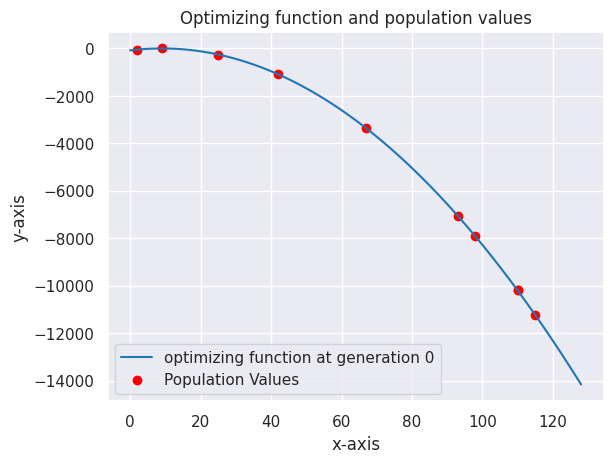

-11236 -11236 -1764 -3249 -11236 -11236 -36 -11025 -11025 -36 roulette wheel weights :  [0.8441154843990621, 1.6882309687981243, 2.6637578212794297, 3.6186822791659154, 4.462797763564978, 5.30691324796404, 6.306413795973863, 7.15345662398202, 8.000499451990178, 9.0]
random number :  0.861875822397569
roulette wheel :  [0.8441154843990621, 1.6882309687981243, 2.6637578212794297, 3.6186822791659154, 4.462797763564978, 5.30691324796404, 6.306413795973863, 7.15345662398202, 8.000499451990178, 9.0]
selected :  1
roulette wheel weights :  [0.8441154843990621, 1.6882309687981243, 2.6637578212794297, 3.6186822791659154, 4.462797763564978, 5.30691324796404, 6.306413795973863, 7.15345662398202, 8.000499451990178, 9.0]
random number :  0.8564425077288067
roulette wheel :  [0.8441154843990621, 1.6882309687981243, 2.6637578212794297, 3.6186822791659154, 4.462797763564978, 5.30691324796404, 6.306413795973863, 7.15345662398202, 8.000499451990178, 9.0]
selected :  1
roulette wheel weights :  [0.844115

<Figure size 640x480 with 0 Axes>

-11236 -11236 -8100 -11236 -11236 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.8971288361532264, 1.7942576723064527, 2.7200981469274153, 3.6172269830806414, 4.5143558192338675, 5.411484655387094, 6.30861349154032, 7.205742327693546, 8.102871163846773, 9.0]
random number :  0.07458018530399302
roulette wheel :  [0.8971288361532264, 1.7942576723064527, 2.7200981469274153, 3.6172269830806414, 4.5143558192338675, 5.411484655387094, 6.30861349154032, 7.205742327693546, 8.102871163846773, 9.0]
selected :  0
roulette wheel weights :  [0.8971288361532264, 1.7942576723064527, 2.7200981469274153, 3.6172269830806414, 4.5143558192338675, 5.411484655387094, 6.30861349154032, 7.205742327693546, 8.102871163846773, 9.0]
random number :  0.1667777307378493
roulette wheel :  [0.8971288361532264, 1.7942576723064527, 2.7200981469274153, 3.6172269830806414, 4.5143558192338675, 5.411484655387094, 6.30861349154032, 7.205742327693546, 8.102871163846773, 9.0]
selected :  0
roulette wheel wei

<Figure size 640x480 with 0 Axes>

-11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.11382852889752526
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.28756420549470896
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.22812469979814687
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
rou

<Figure size 640x480 with 0 Axes>

-11236 -11236 -11025 -11236 -11236 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.8998118574396562, 1.7996237148793124, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
random number :  0.9654625433521365
roulette wheel :  [0.8998118574396562, 1.7996237148793124, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
selected :  1
roulette wheel weights :  [0.8998118574396562, 1.7996237148793124, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
random number :  0.41457932294574484
roulette wheel :  [0.8998118574396562, 1.7996237148793124, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
selected :  0
roulette wheel we

<Figure size 640x480 with 0 Axes>

-11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -8100 roulette wheel weights :  [0.8971288361532264, 1.7942576723064527, 2.6913865084596793, 3.5885153446129054, 4.485644180766132, 5.382773016919358, 6.279901853072584, 7.17703068922581, 8.074159525379036, 8.999999999999998]
random number :  0.9562321401259242
roulette wheel :  [0.8971288361532264, 1.7942576723064527, 2.6913865084596793, 3.5885153446129054, 4.485644180766132, 5.382773016919358, 6.279901853072584, 7.17703068922581, 8.074159525379036, 8.999999999999998]
selected :  1
roulette wheel weights :  [0.8971288361532264, 1.7942576723064527, 2.6913865084596793, 3.5885153446129054, 4.485644180766132, 5.382773016919358, 6.279901853072584, 7.17703068922581, 8.074159525379036, 8.999999999999998]
random number :  0.4306470745980151
roulette wheel :  [0.8971288361532264, 1.7942576723064527, 2.6913865084596793, 3.5885153446129054, 4.485644180766132, 5.382773016919358, 6.279901853072584, 7.17703068922581, 8.074159525379036, 

<Figure size 640x480 with 0 Axes>

-11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.12748280422580782
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.32079585690513335
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5732058098396795
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roul

<Figure size 640x480 with 0 Axes>

-11236 -11236 -11236 -11236 -12100 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.9007630890977179, 1.8015261781954357, 2.7022892672931533, 3.6030523563908714, 4.496184554511411, 5.3969476436091295, 6.297710732706848, 7.198473821804566, 8.099236910902283, 9.0]
random number :  0.8252809534570562
roulette wheel :  [0.9007630890977179, 1.8015261781954357, 2.7022892672931533, 3.6030523563908714, 4.496184554511411, 5.3969476436091295, 6.297710732706848, 7.198473821804566, 8.099236910902283, 9.0]
selected :  0
roulette wheel weights :  [0.9007630890977179, 1.8015261781954357, 2.7022892672931533, 3.6030523563908714, 4.496184554511411, 5.3969476436091295, 6.297710732706848, 7.198473821804566, 8.099236910902283, 9.0]
random number :  0.9409342334635675
roulette wheel :  [0.9007630890977179, 1.8015261781954357, 2.7022892672931533, 3.6030523563908714, 4.496184554511411, 5.3969476436091295, 6.297710732706848, 7.198473821804566, 8.099236910902283, 9.0]
selected :  1
roulette wheel

<Figure size 640x480 with 0 Axes>

-11025 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 -11236 roulette wheel weights :  [0.9016932830430945, 1.8015051404827507, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
random number :  0.5300582815635534
roulette wheel :  [0.9016932830430945, 1.8015051404827507, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
selected :  0
roulette wheel weights :  [0.9016932830430945, 1.8015051404827507, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
random number :  0.5937942555585334
roulette wheel :  [0.9016932830430945, 1.8015051404827507, 2.7013169979224068, 3.601128855362063, 4.500940712801719, 5.400752570241375, 6.300564427681031, 7.2003762851206865, 8.100188142560343, 9.0]
selected :  0
roulette wheel wei

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -1681 -11025 -11025 -11025 roulette wheel weights :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.453699482686857, 5.344439379224228, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
random number :  0.8874802802006417
roulette wheel :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.453699482686857, 5.344439379224228, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
selected :  0
roulette wheel weights :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.453699482686857, 5.344439379224228, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
random number :  0.7508876894243871
roulette wheel :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.453699482686857, 5.344439379224228, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
selected :  0
roulette wheel weights 

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11881 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.496147822799848, 5.396918258239879, 6.297688693679909, 7.198459129119939, 8.09922956455997, 9.0]
random number :  0.05093053588182472
roulette wheel :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.496147822799848, 5.396918258239879, 6.297688693679909, 7.198459129119939, 8.09922956455997, 9.0]
selected :  0
roulette wheel weights :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.496147822799848, 5.396918258239879, 6.297688693679909, 7.198459129119939, 8.09922956455997, 9.0]
random number :  0.26558487189919266
roulette wheel :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.496147822799848, 5.396918258239879, 6.297688693679909, 7.198459129119939, 8.09922956455997, 9.0]
selected :  0
roulette wheel weights :

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.9388429981153782
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  1
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7350928374794333
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.31678828134929293
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11881 roulette wheel weights :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.503852177200151, 5.404622612640181, 6.305393048080211, 7.206163483520242, 8.106933918960271, 8.999999999999998]
random number :  0.6232844301417177
roulette wheel :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.503852177200151, 5.404622612640181, 6.305393048080211, 7.206163483520242, 8.106933918960271, 8.999999999999998]
selected :  0
roulette wheel weights :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.503852177200151, 5.404622612640181, 6.305393048080211, 7.206163483520242, 8.106933918960271, 8.999999999999998]
random number :  0.952318129394219
roulette wheel :  [0.9007704354400302, 1.8015408708800604, 2.7023113063200905, 3.603081741760121, 4.503852177200151, 5.404622612640181, 6.305393048080211, 7.206163483520242, 8.106933918960271, 

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11236 -11025 roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.099808982355764, 9.0]
random number :  0.8885071421098119
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.099808982355764, 9.0]
selected :  0
roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.099808982355764, 9.0]
random number :  0.7261678588673759
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.099808982355764, 9.0]
selected :  0
roulette wheel weights :  [0.9

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -10609 -11025 -11025 -7921 -11025 roulette wheel weights :  [0.8967019582123115, 1.793403916424623, 2.6901058746369344, 3.586807832849246, 4.483509791061557, 5.384109435022955, 6.2808113932352665, 7.177513351447578, 8.103298041787689, 9.0]
random number :  0.681762714731912
roulette wheel :  [0.8967019582123115, 1.793403916424623, 2.6901058746369344, 3.586807832849246, 4.483509791061557, 5.384109435022955, 6.2808113932352665, 7.177513351447578, 8.103298041787689, 9.0]
selected :  0
roulette wheel weights :  [0.8967019582123115, 1.793403916424623, 2.6901058746369344, 3.586807832849246, 4.483509791061557, 5.384109435022955, 6.2808113932352665, 7.177513351447578, 8.103298041787689, 9.0]
random number :  0.5752213240135443
roulette wheel :  [0.8967019582123115, 1.793403916424623, 2.6901058746369344, 3.586807832849246, 4.483509791061557, 5.384109435022955, 6.2808113932352665, 7.177513351447578, 8.103298041787689, 9.0]
selected :  0
roulette wheel weights :

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.41158765847336953
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.9889093679753569
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  1
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5884896685691903
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11236 roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.10171915879813, 9.000000000000002]
random number :  0.8905338552321123
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.10171915879813, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.10171915879813, 9.000000000000002]
random number :  0.29656281024048736
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.401146105865419, 6.301337123509656, 7.201528141153893, 8.10171915879813, 9.00000000

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -10609 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.5827259229973493
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.9673741642116139
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  1
roulette wheel weights

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -10609 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.42988098458542845
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.5705673179300146
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.698863739825555, 3.598484986434073, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weight

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.2191807296915964
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6493013488388437
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.38563197790286874
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.27685282359877095
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5501901165681393
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.17138874044221175
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roul

<Figure size 640x480 with 0 Axes>

-11025 -11025 -10609 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.6084527752009737
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights :  [0.8996212466085183, 1.7992424932170366, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.7230830941274488
roulette wheel :  [0.8996212466085183, 1.7992424932170366, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.18297203741881107
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.26164372575747574
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7193890664203058
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roul

<Figure size 640x480 with 0 Axes>

-11025 -11025 -7921 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.8971030183114629, 1.7942060366229258, 2.72027887181976, 3.617381890131223, 4.514484908442686, 5.411587926754149, 6.308690945065612, 7.205793963377075, 8.102896981688538, 9.0]
random number :  0.8363881093618474
roulette wheel :  [0.8971030183114629, 1.7942060366229258, 2.72027887181976, 3.617381890131223, 4.514484908442686, 5.411587926754149, 6.308690945065612, 7.205793963377075, 8.102896981688538, 9.0]
selected :  0
roulette wheel weights :  [0.8971030183114629, 1.7942060366229258, 2.72027887181976, 3.617381890131223, 4.514484908442686, 5.411587926754149, 6.308690945065612, 7.205793963377075, 8.102896981688538, 9.0]
random number :  0.24664160075236197
roulette wheel :  [0.8971030183114629, 1.7942060366229258, 2.72027887181976, 3.617381890131223, 4.514484908442686, 5.411587926754149, 6.308690945065612, 7.205793963377075, 8.102896981688538, 9.0]
selected :  0
roulette wheel weights :  [0.8

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -7921 -11025 -11025 -11025 roulette wheel weights :  [0.8971030183114629, 1.7942060366229258, 2.6913090549343885, 3.5884120732458515, 4.485515091557314, 5.382618109868777, 6.308690945065611, 7.205793963377074, 8.102896981688536, 8.999999999999998]
random number :  0.6081230136012877
roulette wheel :  [0.8971030183114629, 1.7942060366229258, 2.6913090549343885, 3.5884120732458515, 4.485515091557314, 5.382618109868777, 6.308690945065611, 7.205793963377074, 8.102896981688536, 8.999999999999998]
selected :  0
roulette wheel weights :  [0.8971030183114629, 1.7942060366229258, 2.6913090549343885, 3.5884120732458515, 4.485515091557314, 5.382618109868777, 6.308690945065611, 7.205793963377074, 8.102896981688536, 8.999999999999998]
random number :  0.5721849289858063
roulette wheel :  [0.8971030183114629, 1.7942060366229258, 2.6913090549343885, 3.5884120732458515, 4.485515091557314, 5.382618109868777, 6.308690945065611, 7.205793963377074, 8.1028969816885

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.8236116220892361
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.9036787262655964
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  1
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.23992721057673405
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -5329 -11025 -11025 roulette wheel weights :  [0.8945520974807276, 1.7891041949614552, 2.683656292442183, 3.5782083899229105, 4.472760487403638, 5.367312584884366, 6.261864682365093, 7.210895805038544, 8.105447902519272, 9.0]
random number :  0.49938662114830346
roulette wheel :  [0.8945520974807276, 1.7891041949614552, 2.683656292442183, 3.5782083899229105, 4.472760487403638, 5.367312584884366, 6.261864682365093, 7.210895805038544, 8.105447902519272, 9.0]
selected :  0
roulette wheel weights :  [0.8945520974807276, 1.7891041949614552, 2.683656292442183, 3.5782083899229105, 4.472760487403638, 5.367312584884366, 6.261864682365093, 7.210895805038544, 8.105447902519272, 9.0]
random number :  0.03416531047990434
roulette wheel :  [0.8945520974807276, 1.7891041949614552, 2.683656292442183, 3.5782083899229105, 4.472760487403638, 5.367312584884366, 6.261864682365093, 7.210895805038544, 8.105447902519272, 9.0]
selected :  0
roulette wheel weight

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7598787604784191
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.8666503611779548
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5177660752930893
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6273775356355568
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.8988876418844709
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6713704232603768
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -1681 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.546300517313143, 5.437040413850514, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
random number :  0.3462160176369091
roulette wheel :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.546300517313143, 5.437040413850514, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
selected :  0
roulette wheel weights :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.546300517313143, 5.437040413850514, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
random number :  0.17434372624650074
roulette wheel :  [0.8907398965373714, 1.7814797930747428, 2.672219689612114, 3.5629595861494856, 4.546300517313143, 5.437040413850514, 6.327780310387886, 7.218520206925257, 8.109260103462628, 9.0]
selected :  0
roulette wheel weights

<Figure size 640x480 with 0 Axes>

-11025 -11236 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9001910176442365, 1.7984718588461086, 2.698662876490345, 3.5988538941345816, 4.499044911778818, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
random number :  0.41876277176968535
roulette wheel :  [0.9001910176442365, 1.7984718588461086, 2.698662876490345, 3.5988538941345816, 4.499044911778818, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
selected :  0
roulette wheel weights :  [0.9001910176442365, 1.7984718588461086, 2.698662876490345, 3.5988538941345816, 4.499044911778818, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
random number :  0.6760876972008132
roulette wheel :  [0.9001910176442365, 1.7984718588461086, 2.698662876490345, 3.5988538941345816, 4.499044911778818, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
selected :  0
roulette wheel weight

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11236 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
random number :  0.49319678019859703
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
selected :  0
roulette wheel weights :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
random number :  0.010243664406657138
roulette wheel :  [0.9001910176442365, 1.800382035288473, 2.700573052932709, 3.600764070576946, 4.500955088221183, 5.399235929423055, 6.299426947067292, 7.199617964711528, 8.099808982355764, 9.0]
selected :  0
roulette wheel weights :  [

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.15238661534396358
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7158591116282939
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6293627723152369
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-11025 -11025 -11025 -11025 -12769 -7921 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.898751033152723, 1.797502066305446, 2.696253099458169, 3.595004132610892, 4.477739002663238, 5.4049958673891085, 6.303746900541832, 7.202497933694555, 8.101248966847278, 9.0]
random number :  0.8128276083931448
roulette wheel :  [0.898751033152723, 1.797502066305446, 2.696253099458169, 3.595004132610892, 4.477739002663238, 5.4049958673891085, 6.303746900541832, 7.202497933694555, 8.101248966847278, 9.0]
selected :  0
roulette wheel weights :  [0.898751033152723, 1.797502066305446, 2.696253099458169, 3.595004132610892, 4.477739002663238, 5.4049958673891085, 6.303746900541832, 7.202497933694555, 8.101248966847278, 9.0]
random number :  0.3907106285815858
roulette wheel :  [0.898751033152723, 1.797502066305446, 2.696253099458169, 3.595004132610892, 4.477739002663238, 5.4049958673891085, 6.303746900541832, 7.202497933694555, 8.101248966847278, 9.0]
selected :  0
roulette wheel weights :  [0.89

<Figure size 640x480 with 0 Axes>

-10609 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 -11025 roulette wheel weights :  [0.9034087805233352, 1.8030300271318533, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.6014488504618934
roulette wheel :  [0.9034087805233352, 1.8030300271318533, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights :  [0.9034087805233352, 1.8030300271318533, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
random number :  0.5370854701585166
roulette wheel :  [0.9034087805233352, 1.8030300271318533, 2.7026512737403716, 3.60227252034889, 4.501893766957409, 5.401515013565927, 6.301136260174445, 7.2007575067829634, 8.100378753391482, 9.0]
selected :  0
roulette wheel weights

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.27710130998324634
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.301038192743854
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7697769974964834
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.23543732979149068
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.44074232990779183
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.8407151466221572
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roul

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.19160615295370753
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.04066033028946037
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.720331213953235
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-10609 -10609 -11025 -10609 -10609 -10609 -10609 -10609 -10816 -10609 roulette wheel weights :  [0.9005838089080056, 1.8011676178160112, 2.697853120050978, 3.5984369289589835, 4.499020737866989, 5.399604546774994, 6.300188355683, 7.200772164591005, 8.099416191091994, 9.0]
random number :  0.5912506050535433
roulette wheel :  [0.9005838089080056, 1.8011676178160112, 2.697853120050978, 3.5984369289589835, 4.499020737866989, 5.399604546774994, 6.300188355683, 7.200772164591005, 8.099416191091994, 9.0]
selected :  0
roulette wheel weights :  [0.9005838089080056, 1.8011676178160112, 2.697853120050978, 3.5984369289589835, 4.499020737866989, 5.399604546774994, 6.300188355683, 7.200772164591005, 8.099416191091994, 9.0]
random number :  0.8759432033251506
roulette wheel :  [0.9005838089080056, 1.8011676178160112, 2.697853120050978, 3.5984369289589835, 4.499020737866989, 5.399604546774994, 6.300188355683, 7.200772164591005, 8.099416191091994, 9.0]
selected :  0
roulette wheel weights :  [0.90058

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10816 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9001947373867559, 1.8003894747735119, 2.7005842121602677, 3.6007789495470237, 4.49902631306622, 5.399221050452976, 6.299415787839732, 7.199610525226488, 8.099805262613243, 8.999999999999998]
random number :  0.5640937200010508
roulette wheel :  [0.9001947373867559, 1.8003894747735119, 2.7005842121602677, 3.6007789495470237, 4.49902631306622, 5.399221050452976, 6.299415787839732, 7.199610525226488, 8.099805262613243, 8.999999999999998]
selected :  0
roulette wheel weights :  [0.9001947373867559, 1.8003894747735119, 2.7005842121602677, 3.6007789495470237, 4.49902631306622, 5.399221050452976, 6.299415787839732, 7.199610525226488, 8.099805262613243, 8.999999999999998]
random number :  0.33261000324414447
roulette wheel :  [0.9001947373867559, 1.8003894747735119, 2.7005842121602677, 3.6007789495470237, 4.49902631306622, 5.399221050452976, 6.299415787839732, 7.199610525226488, 8.099805262613243

<Figure size 640x480 with 0 Axes>

-10609 -10609 -11025 -10609 -11449 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9011700482551749, 1.8023400965103498, 2.699634825703799, 3.600804873958974, 4.494149758724126, 5.395319806979301, 6.2964898552344755, 7.19765990348965, 8.098829951744825, 9.0]
random number :  0.5891501659577888
roulette wheel :  [0.9011700482551749, 1.8023400965103498, 2.699634825703799, 3.600804873958974, 4.494149758724126, 5.395319806979301, 6.2964898552344755, 7.19765990348965, 8.098829951744825, 9.0]
selected :  0
roulette wheel weights :  [0.9011700482551749, 1.8023400965103498, 2.699634825703799, 3.600804873958974, 4.494149758724126, 5.395319806979301, 6.2964898552344755, 7.19765990348965, 8.098829951744825, 9.0]
random number :  0.93799411860922
roulette wheel :  [0.9011700482551749, 1.8023400965103498, 2.699634825703799, 3.600804873958974, 4.494149758724126, 5.395319806979301, 6.2964898552344755, 7.19765990348965, 8.098829951744825, 9.0]
selected :  1
roulette wheel weights :  [0

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -11449 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9007855606471523, 1.8015711212943046, 2.702356681941457, 3.6031422425886093, 4.4960721967642385, 5.396857757411391, 6.297643318058544, 7.1984288787056965, 8.09921443935285, 9.000000000000002]
random number :  0.15745106066578063
roulette wheel :  [0.9007855606471523, 1.8015711212943046, 2.702356681941457, 3.6031422425886093, 4.4960721967642385, 5.396857757411391, 6.297643318058544, 7.1984288787056965, 8.09921443935285, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9007855606471523, 1.8015711212943046, 2.702356681941457, 3.6031422425886093, 4.4960721967642385, 5.396857757411391, 6.297643318058544, 7.1984288787056965, 8.09921443935285, 9.000000000000002]
random number :  0.88900340440697
roulette wheel :  [0.9007855606471523, 1.8015711212943046, 2.702356681941457, 3.6031422425886093, 4.4960721967642385, 5.396857757411391, 6.297643318058544, 7.1984288787056965, 8.099214439352

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6212423508738251
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5277875819154395
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.4740885392437303
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.20906180806982078
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.24523563617415067
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.9028288277440867
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  1
roul

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.2418562057461311
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7602760352808927
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.14250408724025587
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roule

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -11236 -10609 roulette wheel weights :  [0.9005875352568007, 1.8011750705136014, 2.7017626057704023, 3.6023501410272027, 4.502937676284003, 5.403525211540804, 6.304112746797604, 7.204700282054405, 8.099412464743198, 8.999999999999998]
random number :  0.32363268847419246
roulette wheel :  [0.9005875352568007, 1.8011750705136014, 2.7017626057704023, 3.6023501410272027, 4.502937676284003, 5.403525211540804, 6.304112746797604, 7.204700282054405, 8.099412464743198, 8.999999999999998]
selected :  0
roulette wheel weights :  [0.9005875352568007, 1.8011750705136014, 2.7017626057704023, 3.6023501410272027, 4.502937676284003, 5.403525211540804, 6.304112746797604, 7.204700282054405, 8.099412464743198, 8.999999999999998]
random number :  0.1628688450565322
roulette wheel :  [0.9005875352568007, 1.8011750705136014, 2.7017626057704023, 3.6023501410272027, 4.502937676284003, 5.403525211540804, 6.304112746797604, 7.204700282054405, 8.09941246474

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.9970294291865173
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  1
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6373625848388927
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.6545362858774049
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -12321 -10609 -10609 roulette wheel weights :  [0.9015880966957941, 1.8031761933915882, 2.7047642900873825, 3.6063523867831764, 4.50794048347897, 5.409528580174764, 6.311116676870558, 7.1968238066084105, 8.098411903304205, 9.0]
random number :  0.238386579341184
roulette wheel :  [0.9015880966957941, 1.8031761933915882, 2.7047642900873825, 3.6063523867831764, 4.50794048347897, 5.409528580174764, 6.311116676870558, 7.1968238066084105, 8.098411903304205, 9.0]
selected :  0
roulette wheel weights :  [0.9015880966957941, 1.8031761933915882, 2.7047642900873825, 3.6063523867831764, 4.50794048347897, 5.409528580174764, 6.311116676870558, 7.1968238066084105, 8.098411903304205, 9.0]
random number :  0.3724161801852318
roulette wheel :  [0.9015880966957941, 1.8031761933915882, 2.7047642900873825, 3.6063523867831764, 4.50794048347897, 5.409528580174764, 6.311116676870558, 7.1968238066084105, 8.098411903304205, 9.0]
selected :  0
roulette wheel weig

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.572880908179985
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7458231000151908
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.19961770653650313
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulet

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.010457841155474323
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.5011851994385981
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roulette wheel weights :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
random number :  0.7629029440642028
roulette wheel :  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.300000000000001, 7.200000000000001, 8.100000000000001, 9.000000000000002]
selected :  0
roul

<Figure size 640x480 with 0 Axes>

-10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 -10609 Max value by genetic = -10609 for x = [1, 1, 1, 0, 0, 0, 0] 


<Figure size 640x480 with 0 Axes>

In [ ]:
#6. Genetic Algorithm

import random
import numpy as np
import math
import matplotlib.pyplot as plt


# Function to convert a binary list to a single integer
def binary_to_int(binary_list):
    decimal_value = 0
    power = len(binary_list) - 1

    for digit in binary_list:
        decimal_value += digit * (2 ** power)
        power -= 1

    return decimal_value

def plot_fitness(function,discrete_x,discrete_y,lim_range,generation):
    # Create x values for the continuous function
    # Creating 100 values in the lim_range of 0 to 16
    x = np.linspace(0, lim_range+1, 100)
    # Calculate the y values for the continuous function
    y_continuous = function(x)

    # Create the plot
    plt.plot(x, y_continuous, label='optimizing function at generation {0}'.format(generation))
    sc = plt.scatter(discrete_x, discrete_y, color='red', label='Population Values')

    # Add labels, title, and legend
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Optimizing function and population values')
    plt.legend()

    # Display the plot
    plt.grid(True)
    return sc

def update(sc,discrete_x,discrete_y):
    print("discrete x : ",discrete_x)
    plt.pause(0.01)
    sc.set_offsets(np.c_[discrete_x,discrete_y])
    plt.draw()

# Randomly initialize a population
def init_population(population_size, bits):
    population = []
    for _ in range(population_size):
        chromosome = [random.randint(0,1) for _ in range(bits)]
        population.append(chromosome)
    return population

# Calculate the fitness for the entire population
def get_fitness(population,fitness_fn):
    fitness = []
    int_values = []
    for chr in population:
        # Convert the list into an integer
        int_conv = binary_to_int(chr)
        int_values.append(int_conv)
        fitness.append(fitness_fn(int_conv))

    return fitness,int_values

# Select a randon individual based o roulette wheel selection
def roulette_wheel_selection(fitness):
    # Determining the probabilities of selection
    fit_sum = sum(fitness)
    fitness_prob_weights = [1 - (fit/fit_sum )for fit in fitness]
    roulette_wheel = []
    roulette_wheel.append(fitness_prob_weights[0])

    # Generating a roulette wheel
    for fwi,fw in enumerate(fitness_prob_weights):
        if fwi != 0:
            roulette_wheel.append(roulette_wheel[fwi-1]+fw)
    print("roulette wheel weights : ",roulette_wheel)

    # Generate a random number
    rand_num = random.random()
    print("random number : ",rand_num)
    print("roulette wheel : ",roulette_wheel)
    for i,weight in enumerate(roulette_wheel):
        if rand_num  < weight:
            print("selected : ",i)
            return i

# Function to perform single point crossover in 2 inds
def single_point_crossover(parent1,parent2):
    # Ensure both parents have the same length
    assert len(parent1) == len(parent2)
    # Choosing a random poin to swap from
    x = random.randint(0,len(parent1))
    # Randomly select a crossover point
    crossover_point = random.randint(1, len(parent1) - 1)

    # Perform crossover to create two offspring individuals
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    return offspring1, offspring2

# Defining bitflip mutation
def bitflip_mutation(chromosome,mutation_rate):
    for i,chrome in enumerate(chromosome):
        # Generate a random number
        random_mutation_num = random.random()
        if random_mutation_num < mutation_rate:
            if chrome == 0:
                chromosome[i] = 1
            else:
                chromosome[i] = 0
    return chromosome



def genetic_optimize(fitness_fn,population_size,crossover_rate,mutation_rate,lim_range,total_generations):
    plt.show()
    # Finding the number of bits required to initialize the population
    bits = int(math.log2(lim_range)+1)
    # Generating a random popultation
    population = init_population(population_size,bits)
    print("Initial population : ",population)
    fitness,int_values = get_fitness(population,fitness_fn)
    # Plotting the fitness function and fitness of the population
    plt_sc = plot_fitness(fitness_fn,int_values,fitness,lim_range,0)

    # Running the genetic algorithm for a set of generations
    for generation_i in range(total_generations):

        new_generation = []

        while len(new_generation) < population_size:
            # selecting 2 random individuals for crossover
            ind1 = roulette_wheel_selection(fitness)
            ind2 = roulette_wheel_selection(fitness)

            # Setting a random probability for genetic crossover
            crossover_prob = random.random()
            if crossover_prob < crossover_rate:
                offspring1, offspring2 = single_point_crossover(population[ind1], population[ind2])

                # Random mutation
                mutant_1 = bitflip_mutation(offspring1,mutation_rate)
                mutant_2 = bitflip_mutation(offspring2,mutation_rate)

                new_generation.append(mutant_1)
                new_generation.append(mutant_2)

        population = new_generation.copy()
        fitness,int_values = get_fitness(population,fitness_fn)

        # Plotting the fitness function and fitness of the population
        update(plt_sc,int_values,fitness)

        for i in fitness:
            print(i, end = " ")

    return max(fitness),population[fitness.index(max(fitness))]


def main():
    POPULATION_SIZE = 10
    CROSSOVER_RATE = 0.7
    MUTATION_RATE = 0.01
    FITNESS_FN = lambda x : -1*(x-9)**2
    LIM_RANGE = 127

    TOTAL_GENERATIONS = 50

    max_value, x_value = genetic_optimize(FITNESS_FN,POPULATION_SIZE,CROSSOVER_RATE,MUTATION_RATE,LIM_RANGE,TOTAL_GENERATIONS)
    print("Max value by genetic = {0} for x = {1} ".format(max_value,x_value))

main()

Optimal Solution (closest to zero): [0.21407991 0.00058878]


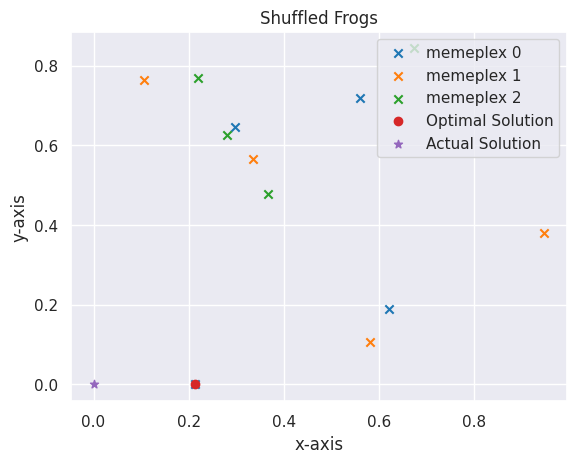

In [ ]:
#7. Swarm Intelligence

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

def opt_func(value):
    """The mathematical function to optimize. Here it calculates the distance to origin,
    i.e. optimal solution(minimum) is at 0.

    Arguments:
        value {np.ndarray} -- An individual value or frog

    Returns:
        float -- The output value or fitness of the frog
    """

    output = np.sqrt((value ** 2).sum())
    return output

def gen_frogs(frogs, dimension, sigma, mu):
    """Generates a random frog population from gaussian normal distribution.

    Arguments:
        frogs {int} -- Number of frogs
        dimension {int} -- Dimension of frogs/ Number of features
        sigma {int/float} -- Sigma of gaussian distribution
        mu {int/float} -- Mu of Gaussian distribution

    Returns:
        numpy.ndarray -- A frogs x dimension array
    """
    frogs = sigma * (np.random.rand(frogs, dimension)) + mu
    return frogs

def sort_frogs(frogs, mplx_no, opt_func):
    """Sorts the frogs in decending order of fitness by the given function.

    Arguments:
        frogs {numpy.ndarray} -- Frogs to be sorted
        mplx_no {int} -- Number of memeplexes, when divides frog number should return an integer otherwise frogs will be skipped
        opt_func {function} -- Function to determine fitness

    Returns:
        numpy.ndarray -- A memeplexes x frogs/memeplexes array of indices, [0, 0] will be the greatest frog
    """

    # Find fitness of each frog
    fitness = np.array(list(map(opt_func, frogs)))
    # Sort the indices in decending order by fitness
    sorted_fitness = np.argsort(fitness)
    # Empty holder for memeplexes
    memeplexes = np.zeros((mplx_no, int(frogs.shape[0]/mplx_no)))
    # Sort into memeplexes
    for j in range(memeplexes.shape[1]):
        for i in range(mplx_no):
            memeplexes[i, j] = sorted_fitness[i+(mplx_no*j)]
    return memeplexes

def local_search(frogs, memeplex, opt_func, sigma, mu):
    """Performs the local search for a memeplex.

    Arguments:
        frogs {numpy.ndarray} -- All the frogs
        memeplex {numpy.ndarray} -- One memeplex
        opt_func {function} -- The function to optimize
        sigma {int/float} -- Sigma for the gaussian distribution by which the frogs were created
        mu {int/float} -- Mu for the gaussian distribution by which the frogs were created

    Returns:
        numpy.ndarray -- The updated frogs, same dimensions
    """

    # Select worst, best, greatest frogs
    frog_w = frogs[int(memeplex[-1])]
    frog_b = frogs[int(memeplex[0])]
    frog_g = frogs[0]
    # Move worst wrt best frog
    frog_w_new = frog_w + (np.random.rand() * (frog_b - frog_w))
    # If change not better, move worst wrt greatest frog
    if opt_func(frog_w_new) > opt_func(frog_w):
        frog_w_new = frog_w + (np.random.rand() * (frog_g - frog_w))
    # If change not better, random new worst frog
    if opt_func(frog_w_new) > opt_func(frog_w):
        frog_w_new = gen_frogs(1, frogs.shape[1], sigma, mu)[0]
    # Replace worst frog
    frogs[int(memeplex[-1])] = frog_w_new
    return frogs

def shuffle_memeplexes(frogs, memeplexes):
    """Shuffles the memeplexes without sorting them.

    Arguments:
        frogs {numpy.ndarray} -- All the frogs
        memeplexes {numpy.ndarray} -- The memeplexes

    Returns:
        numpy.ndarray -- A shuffled memeplex, unsorted, same dimensions
    """

    # Flatten the array
    temp = memeplexes.flatten()
    #Shuffle the array
    np.random.shuffle(temp)
    # Reshape
    temp = temp.reshape((memeplexes.shape[0], memeplexes.shape[1]))
    return temp

def sfla(opt_func, frogs=30, dimension=2, sigma=1, mu=0, mplx_no=5, mplx_iters=10, solun_iters=50):
    """Performs the Shuffled Leaping Frog Algorithm.

    Arguments:
        opt_func {function} -- The function to optimize.

    Keyword Arguments:
        frogs {int} -- The number of frogs to use (default: {30})
        dimension {int} -- The dimension/number of features (default: {2})
        sigma {int/float} -- Sigma for the gaussian normal distribution to create the frogs (default: {1})
        mu {int/float} -- Mu for the gaussian normal distribution to create the frogs (default: {0})
        mplx_no {int} -- Number of memeplexes, when divides frog number should return an integer otherwise frogs will be skipped (default: {5})
        mplx_iters {int} -- Number of times a single memeplex will be iterated before shuffling (default: {10})
        solun_iters {int} -- Number of times the memeplexes will be shuffled (default: {50})

    Returns:
        tuple(numpy.ndarray, numpy.ndarray, numpy.ndarray) -- [description]
    """

    # Generate frogs around the solution
    frogs = gen_frogs(frogs, dimension, sigma, mu)
    # Arrange frogs and sort into memeplexes
    memeplexes = sort_frogs(frogs, mplx_no, opt_func)
    # Best solution as greatest frog
    best_solun = frogs[int(memeplexes[0, 0])]
    # For the number of iterations
    for i in range(solun_iters):
        # Shuffle memeplexes
        memeplexes = shuffle_memeplexes(frogs, memeplexes)
        # For each memeplex
        for mplx_idx, memeplex in enumerate(memeplexes):
            # For number of memeplex iterations
            for j in range(mplx_iters):
                # Perform local search
                frogs = local_search(frogs, memeplex, opt_func, sigma, mu)
            # Rearrange memeplexes
            memeplexes = sort_frogs(frogs, mplx_no, opt_func)
            # Check and select new best frog as the greatest frog
            new_best_solun = frogs[int(memeplexes[0, 0])]
            if opt_func(new_best_solun) < opt_func(best_solun):
                best_solun = new_best_solun
    return best_solun, frogs, memeplexes.astype(int)

def main():
    # Run algorithm
    solun, frogs, memeplexes = sfla(opt_func, 12, 2, 1, 0, 3, 2, 1)
    print("Optimal Solution (closest to zero): {}".format(solun))
    # Place memeplexes
    for idx, memeplex in enumerate(memeplexes):
        plt.scatter(frogs[memeplex, 0], frogs[memeplex, 1], marker='x', label="memeplex {}".format(idx))
    plt.scatter(solun[0], solun[1], marker='o', label="Optimal Solution")
    plt.scatter(0, 0, marker='*', label='Actual Solution')
    # Plot properties
    plt.legend()
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.title("Shuffled Frogs")
    # Show plot
    plt.show()

if __name__ == '__main__':
    main()